## Main script as ipynb

Load the useful modules

In [1]:
from load_data import load_wepl_file, WEPLData, load_single_modality_from_wepl_file

import numpy as np

import SimpleITK as sitk

%matplotlib inline
from matplotlib import colors
from matplotlib import pyplot as plt

Create a convienient struct for the data and a conversion function:

In [2]:
class WEPLData_sitk:
    rawCBCT = []
    corrCBCT = []
    rigidCT = []
    deformCT = []
    repeatCT = []
    def __init__(self, h, w):
        self.rawCBCT = sitk.Image(h, w, sitk.sitkFloat32)
        self.corrCBCT = sitk.Image(h, w, sitk.sitkFloat32)
        self.rigidCT = sitk.Image(h, w, sitk.sitkFloat32)
        self.deformCT = sitk.Image(h, w, sitk.sitkFloat32)
        self.repeatCT = sitk.Image(h, w, sitk.sitkFloat32)

def resample(image: sitk.Image, ref_image: sitk.Image, dimension = 2):
    # Output image Origin, Spacing, Size, Direction are taken from the reference
    # image in this call to Resample
    reference_image = ref_image
    interpolator = sitk.sitkLinear
    default_value = 0.0
    
    identity_transform = sitk.Transform(dimension, sitk.sitkIdentity)
    return sitk.Resample(image, reference_image, identity_transform,
                         interpolator, default_value)

def wepl_data2sitk(wepl_data: WEPLData, repeatct_data: np.array) -> WEPLData_sitk:
    h,w = wepl_data.rawCBCT.shape
    h_r,w_r = repeatct_data.shape
    out = WEPLData_sitk(h, w)
    out.rawCBCT = sitk.GetImageFromArray(wepl_data.rawCBCT)
    out.corrCBCT = sitk.GetImageFromArray(wepl_data.corrCBCT)
    out.rigidCT = sitk.GetImageFromArray(wepl_data.rigidCT)
    out.deformCT = sitk.GetImageFromArray(wepl_data.deformCT)
    
    repeatCT = sitk.GetImageFromArray(repeatct_data)
    repeatCT.SetSpacing([w/w_r, h/h_r])
    out.repeatCT = resample(repeatCT, out.rigidCT)
    
    return out


Load the data

In [5]:
cbct1_data = load_wepl_file("CBCT1/wepl.txt")
rct_data1 = load_single_modality_from_wepl_file("CBCT1/wepl_rct_as_rigid.txt", 5)
cbct1 = wepl_data2sitk(cbct1_data, rct_data1)

cbct2_data = load_wepl_file("CBCT2/wepl.txt")
rct_data2 = load_single_modality_from_wepl_file("CBCT2/wepl_rCTasRIGID.txt", 5)
cbct2 = wepl_data2sitk(cbct2_data, rct_data2)
    

# Plot data:
First some functions for convienience:

In [128]:
def new_figure(n_rows = 1, n_cols = 1, title = "", colormap = "gray") -> plt.figure:
    fig, axs = plt.subplots(n_rows, n_cols)
    fig.suptitle(title)
    plt.set_cmap(colormap)
    return fig, axs

def show_figure(fig: plt.figure, images, vmin=-69, vmax=69, saveas=""):
    if vmin == -69 and vmax == 69:
        # Find the min and max of all colors for use in setting the color scale.
        vmin = min(image.get_array().min() for image in images)
        vmax = max(image.get_array().max() for image in images)
        # Prefer symmetry
        if vmin < -0.1 and vmax > 0.1:
            vmax = max(vmax, -vmin)
            vmin = -vmax

    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    for im in images:
        im.set_norm(norm)

    # fig.colorbar(images[0], ax=axs, orientation='vertical', fraction=.1)
    
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    cax = plt.axes([0.85, 0.1, 0.075, 0.8])
    fig.colorbar(images[0], cax=cax, orientation='vertical')
    if saveas != "":
        plt.savefig(saveas, bbox_inches="tight", dpi=199)
    else:
        plt.show()
    
    
def subplot(position: int, axs, sitk_image: sitk.Image, subtitle=""):
    pos = (position - 1) % 10
    Nr = int( (position % 100 - pos) / 10 )
    Nc = int( (position - Nr - pos) / 100 )
    i = pos % Nr
    j = int((pos - i) / Nr)
    img = axs[j, i].imshow(sitk.GetArrayViewFromImage(sitk_image), origin="lower")
    axs[j, i].axis("off")
    axs[j, i].set_title(subtitle)
    return img


Now the actual plotting:

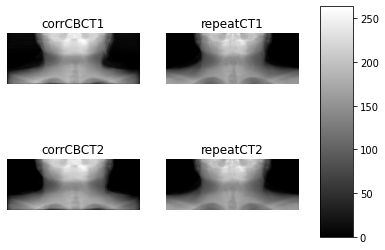

In [129]:
fig, axs = new_figure(2, 2)
images = []
images.append(subplot(221, axs, cbct1.corrCBCT, "corrCBCT1"))
images.append(subplot(222, axs, cbct1.repeatCT, "repeatCT1"))
images.append(subplot(223, axs, cbct2.corrCBCT, "corrCBCT2"))
images.append(subplot(224, axs, cbct2.repeatCT, "repeatCT2"))

show_figure(fig, images)

Hmm, yes...

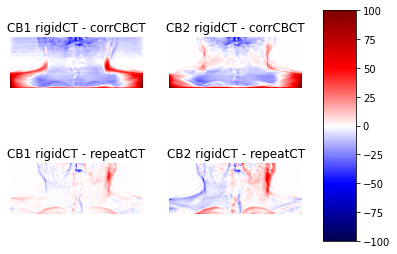

In [130]:
fig, axs = new_figure(2, 2, colormap="seismic")
images = []
images.append(subplot(221, axs, cbct1.rigidCT - cbct1.corrCBCT, "CB1 rigidCT - corrCBCT"))
images.append(subplot(222, axs, cbct2.rigidCT - cbct2.corrCBCT, "CB2 rigidCT - corrCBCT"))
images.append(subplot(223, axs, cbct1.rigidCT - cbct1.repeatCT, "CB1 rigidCT - repeatCT"))
images.append(subplot(224, axs, cbct2.rigidCT - cbct2.repeatCT, "CB2 rigidCT - repeatCT"))

show_figure(fig, images, vmin=-100, vmax = 100)


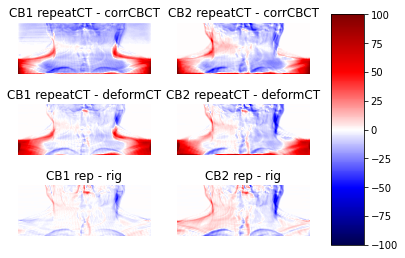

In [131]:

fig, axs = new_figure(3, 2, colormap="seismic")
images = []
images.append(subplot(321, axs, cbct1.repeatCT - cbct1.corrCBCT, "CB1 repeatCT - corrCBCT"))
images.append(subplot(322, axs, cbct2.repeatCT - cbct2.corrCBCT, "CB2 repeatCT - corrCBCT"))

images.append(subplot(323, axs, cbct1.repeatCT - cbct1.deformCT, "CB1 repeatCT - deformCT"))
images.append(subplot(324, axs, cbct2.repeatCT - cbct2.deformCT, "CB2 repeatCT - deformCT"))

images.append(subplot(325, axs, ( cbct1.repeatCT - cbct1.rigidCT), "CB1 rep - rig"))
images.append(subplot(326, axs, ( cbct2.repeatCT - cbct2.rigidCT), "CB2 rep - rig"))

show_figure(fig, images, vmin=-100, vmax=100)

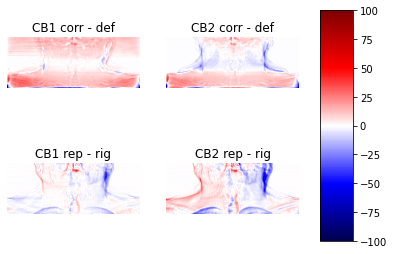

In [132]:

fig, axs = new_figure(2, 2, colormap="seismic")
images = []
images.append(subplot(221, axs, ( cbct1.corrCBCT - cbct1.deformCT), "CB1 corr - def"))
images.append(subplot(222, axs, ( cbct2.corrCBCT - cbct2.deformCT), "CB2 corr - def"))
images.append(subplot(223, axs, ( cbct1.repeatCT - cbct1.rigidCT), "CB1 rep - rig"))
images.append(subplot(224, axs, ( cbct2.repeatCT - cbct2.rigidCT), "CB2 rep - rig"))
show_figure(fig, images, vmin=-100, vmax=100)

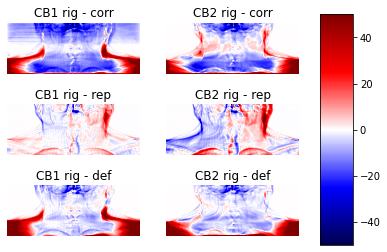

In [135]:
fig, axs = new_figure(3, 2, colormap="seismic")
images = []
images.append(subplot(321, axs, ( cbct1.rigidCT - cbct1.corrCBCT), "CB1 rig - corr"))
images.append(subplot(322, axs, ( cbct2.rigidCT - cbct2.corrCBCT), "CB2 rig - corr"))
images.append(subplot(323, axs, ( cbct1.rigidCT - cbct1.repeatCT), "CB1 rig - rep"))
images.append(subplot(324, axs, ( cbct2.rigidCT - cbct2.repeatCT), "CB2 rig - rep"))
images.append(subplot(325, axs, ( cbct1.rigidCT - cbct1.deformCT), "CB1 rig - def"))
images.append(subplot(326, axs, ( cbct2.rigidCT - cbct2.deformCT), "CB2 rig - def"))
show_figure(fig, images, vmin=-50, vmax=50, saveas="rig_vs_all.pdf")

Not great...